# 규제 선형모델

- 다항식이 복잡해지면서 회귀계수값이 크게 설정되며 과대적합됨
- 선형모델은 비용함수를 최소화해야 함
- 규제선형모델은 alpha패널티를 적용해 회귀계수 크기를 제한함

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Ridge 회귀
- L2 규제를 적용한 회귀모델
- 회귀계수들의 제곱합을 alpha패널티에 곱해 비용산정

In [2]:
from sklearn.model_selection import train_test_split
df = pd.read_csv('../../data/boston_housing_train.csv')

In [4]:
x = df.drop('MEDV', axis=1)
y = df['MEDV']


In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(404, 13) (102, 13) (404,) (102,)


In [6]:
from sklearn.linear_model import Ridge

reg = Ridge(alpha=1.0)
reg.fit(x_train, y_train)
print("Train score:", reg.score(x_train, y_train))
print("Test score:", reg.score(x_test, y_test))

Train score: 0.7487825119234438
Test score: 0.6662221670168522


In [7]:
print("Coefficients:", reg.coef_)

Coefficients: [-1.09234061e-01  3.22706863e-02  7.49805942e-03  2.54546998e+00
 -9.53795159e+00  4.46450537e+00 -1.21910176e-02 -1.33870040e+00
  2.48881816e-01 -1.14746211e-02 -8.28604284e-01  1.26421124e-02
 -5.23833016e-01]


In [9]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error, r2_score
# 다른 평가 지표
def evaluate_regression(y_true, y_pred):
    mse = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    mae = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f'MSE: {mse} RMSE: {rmse},MAE: {mae}, R2: {r2}')

In [23]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

model = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False, degree=2)),
    ('reg', Ridge(alpha=800.0)) # alpha 값을 크게 주면 규제가 강해짐
])

model.fit(x_train, y_train)
print("Train score:", model.score(x_train, y_train))
print("Test score:", model.score(x_test, y_test))
evaluate_regression(y_test, model.predict(x_test))

Train score: 0.9057428426070177
Test score: 0.8248220948117753
MSE: 2.4623720591375324 RMSE: 3.584195657822392,MAE: 0.13288188991551309, R2: 0.8248220948117753


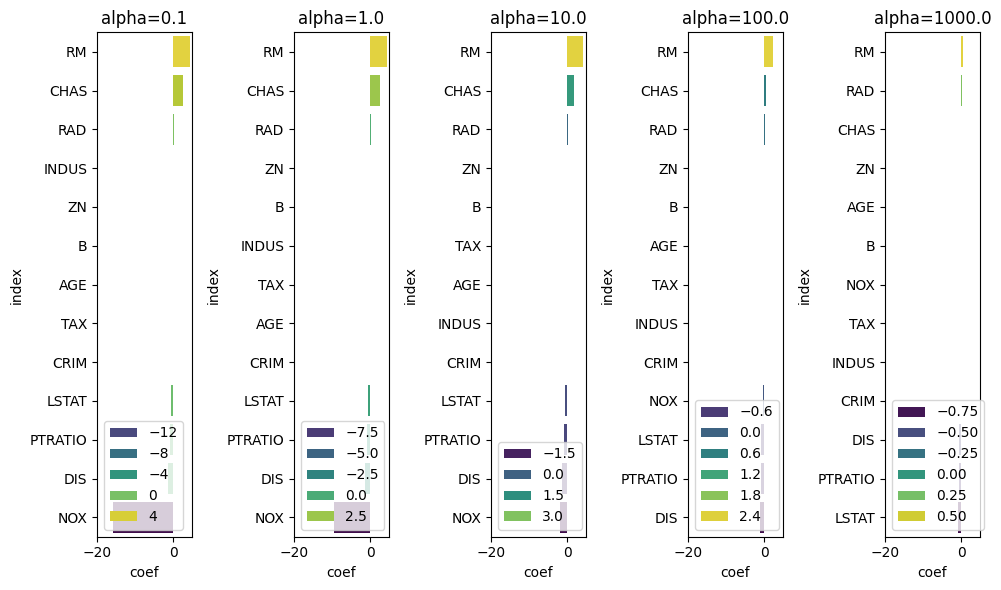

In [28]:
fig, ax = plt.subplots(figsize=(10, 6), nrows=1, ncols=5)
alphas = [0.1, 1.0, 10.0, 100.0, 1000.0]
for i, alpha in enumerate(alphas):
    model = Ridge(alpha=alpha)
    model.fit(x_train, y_train)


    coef_ser = pd.Series(model.coef_, index=x.columns)
    coef_ser.name = f'alpha={alpha}'
    coef_ser = coef_ser.sort_values(ascending=False)
    ax[i].set_title(coef_ser.name)
    ax[i].set_xlabel('coef')
    ax[i].set_ylabel('index')
    ax[i].set_xlim(-20, 5)

    sns.barplot(x=coef_ser.values, y=coef_ser.index, ax=ax[i], hue=coef_ser.values, palette='viridis')
plt.tight_layout()
plt.show()

### Lasso 회귀
- L1규제를 적용한 선형회귀
- 회귀계수 절대값의 합을 alpha값과 곱해 규제 정도 지정
- 회귀계수를 0까지 줄일 수 있음 = 해당특성반영 X

In [33]:
from sklearn.linear_model import Lasso
reg = Lasso(alpha=1)
reg.fit(x_train, y_train)

print("Train score:", reg.score(x_train, y_train))
print("Test score:", reg.score(x_test, y_test))
print("Coefficients:", reg.coef_)

Train score: 0.6959153721670908
Test score: 0.6671453631686304
Coefficients: [-0.07660927  0.02850064 -0.          0.         -0.          1.63048892
  0.01639478 -0.63085765  0.21965363 -0.01228558 -0.70858233  0.0111811
 -0.74710661]


### ElasticNet 회귀
- L1, L2 규제를 모두 적용한 선형회귀

**하이퍼 파라미터**
- alpha: 규제 강도
- L1_ratio: L1 규제와 L2 규제의 비율 (0~1 사이 값)
  - 0: 릿지 회귀
  - 1: 라쏘 회귀
  - 0.5: L1, L2 규제를 동일하게 적용

In [34]:
from sklearn.linear_model import ElasticNet

reg = ElasticNet(alpha=1.0, l1_ratio=0.5)
reg.fit(x_train, y_train)
print("Train score:", reg.score(x_train, y_train))
print("Test score:", reg.score(x_test, y_test))
print("Coefficients:", reg.coef_)

Train score: 0.6908083499815865
Test score: 0.6731556429073877
Coefficients: [-0.09329918  0.03557051 -0.02012984  0.         -0.          1.16299643
  0.01859135 -0.7554234   0.27598038 -0.01427315 -0.7527046   0.01101275
 -0.77557569]


In [59]:
alphas = np.arange(0, 900, 10)
l1_ratios = np.arange(0, 1, 0.1)

best_score = -np.inf
best_params = {}

for alpha in alphas:
    for l1_ratio in l1_ratios:

        model = Pipeline([
            ('poly', PolynomialFeatures(include_bias=False, degree=3)),
            ('reg', ElasticNet(alpha=alpha, l1_ratio=l1_ratio))
        ])
        
        model.fit(x_train, y_train)
        score = model.score(x_test, y_test)

        if score > best_score:
            best_score = score
            best_params = {'alpha': alpha, 'l1_ratio': l1_ratio}

print(f'best 파라미터: {best_params}, 최고점수: {best_score:.4f}')
print(model.score(x_train, y_train), model.score(x_test, y_test))
print(evaluate_regression(y_test, model.predict(x_test)))


c:\Users\Playdata\anaconda3\envs\ml_env\Lib\site-packages\sklearn\base.py:1365: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
c:\Users\Playdata\anaconda3\envs\ml_env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
c:\Users\Playdata\anaconda3\envs\ml_env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.043e+02, tolerance: 3.510e+00
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead

best 파라미터: {'alpha': np.int64(520), 'l1_ratio': np.float64(0.7000000000000001)}, 최고점수: 0.8512
0.8954670158968789 0.8393030577945126
MSE: 2.3003419769692233 RMSE: 3.432858097012483,MAE: 0.12142666163366117, R2: 0.8393030577945126
None


c:\Users\Playdata\anaconda3\envs\ml_env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.153e+03, tolerance: 3.510e+00
  model = cd_fast.enet_coordinate_descent(
c:\Users\Playdata\anaconda3\envs\ml_env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.179e+03, tolerance: 3.510e+00
  model = cd_fast.enet_coordinate_descent(
c:\Users\Playdata\anaconda3\envs\ml_env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing reg

In [ ]:
reg = model.named_steps['reg']
print("Coefficients:", reg.coef_)
print("Intercept:", reg.intercept_)

In [60]:
model = Pipeline([
            ('poly', PolynomialFeatures(include_bias=False, degree=3)),
            ('reg', ElasticNet(alpha=best_params['alpha'], l1_ratio=best_params['l1_ratio']))
        ])

model.fit(x_train, y_train)

print("Train score:", model.score(x_train, y_train))
print("Test score:", model.score(x_test, y_test))

Train score: 0.9048582710661661
Test score: 0.851187116788695


c:\Users\Playdata\anaconda3\envs\ml_env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.090e+03, tolerance: 3.510e+00
  model = cd_fast.enet_coordinate_descent(


In [65]:
model = Pipeline([
            ('poly', PolynomialFeatures(include_bias=False, degree=3)),
            ('reg', ElasticNet(alpha=500, l1_ratio=0.7))
        ])

model.fit(x_train, y_train)

print("Train score:", model.score(x_train, y_train))
print("Test score:", model.score(x_test, y_test))

Train score: 0.9057246421824886
Test score: 0.8511005443116177


c:\Users\Playdata\anaconda3\envs\ml_env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.082e+03, tolerance: 3.510e+00
  model = cd_fast.enet_coordinate_descent(
